In [1]:
import imageio
from PIL import Image
import cv2
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import subprocess

import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
plt.rcParams['figure.dpi'] = 150

import seaborn as sns

from IPython.display import Video, display

#block those warnings from pandas about setting values on a slice
import warnings
warnings.filterwarnings('ignore')

In [2]:
img_labels = pd.read_csv('C:\\Users\\HARSHITHA\\Desktop\\nfl plays\\image_labels.csv')
img_labels.head()

image   label  left  width  top  height
0  57503_000116_Endzone_frame443.jpg  Helmet  1099     16  456      15
1  57503_000116_Endzone_frame443.jpg  Helmet  1117     15  478      16
2  57503_000116_Endzone_frame443.jpg  Helmet   828     16  511      15
3  57503_000116_Endzone_frame443.jpg  Helmet   746     16  519      16
4  57503_000116_Endzone_frame443.jpg  Helmet   678     17  554      17

In [3]:
img_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193736 entries, 0 to 193735
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   image   193736 non-null  object
 1   label   193736 non-null  object
 2   left    193736 non-null  int64 
 3   width   193736 non-null  int64 
 4   top     193736 non-null  int64 
 5   height  193736 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 8.9+ MB


In [4]:
img_name = img_labels['image'][0]
img_name

'57503_000116_Endzone_frame443.jpg'

In [9]:
img_path = f"C:\\Users\\HARSHITHA\\Desktop\\nfl plays/images/{img_name}"

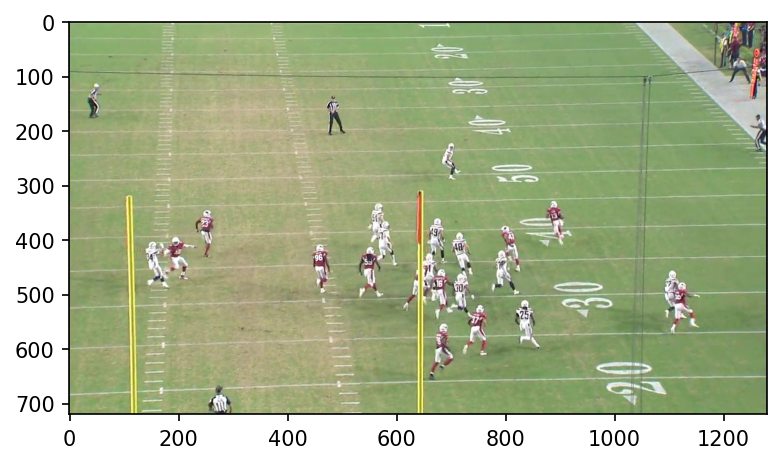

In [10]:
img = imageio.imread(img_path) 
plt.imshow(img)
plt.show()

In [11]:
def add_img_boxes(image_name, image_labels):
    # Set label colors for bounding boxes
    HELMET_COLOR = (0, 0, 0)    # Black

    boxes = img_labels.loc[img_labels['image'] == img_name]
    for j, box in boxes.iterrows():
        color = HELMET_COLOR 

        # Add a box around the helmet
        # Note that cv2.rectangle requires us to specify the top left pixel and the bottom right pixel
        cv2.rectangle(img, (box.left, box.top), (box.left + box.width, box.top + box.height), color, thickness=1)
        
    # Display the image with bounding boxes added
    plt.imshow(img)
    plt.show()

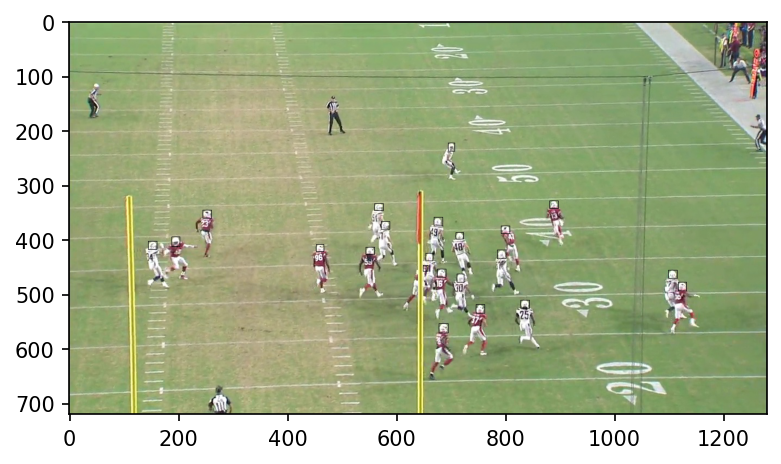

In [12]:
add_img_boxes(img_name, img_labels)

In [13]:
video_labels = pd.read_csv('C:\\Users\\HARSHITHA\\Desktop\\nfl plays/train_labels.csv')
video_labels.head()

gameKey  playID     view                     video  frame label  left  \
0    57583      82  Endzone  57583_000082_Endzone.mp4      1   H30   629   
1    57583      82  Endzone  57583_000082_Endzone.mp4      1   V72   443   
2    57583      82  Endzone  57583_000082_Endzone.mp4      1   V86   871   
3    57583      82  Endzone  57583_000082_Endzone.mp4      1   V74   771   
4    57583      82  Endzone  57583_000082_Endzone.mp4      1   V34   549   

   width  top  height  impact impactType  confidence  visibility  
0     19   40      24     NaN        NaN         NaN         NaN  
1     22  344      16     NaN        NaN         NaN         NaN  
2     21  359      17     NaN        NaN         NaN         NaN  
3     19  345      15     NaN        NaN         NaN         NaN  
4     26  461      20     NaN        NaN         NaN         NaN

In [14]:
video_name = video_labels.dropna().reset_index().iloc[100]['video']
video_path = f"C:\\Users\\HARSHITHA\\Desktop\\nfl plays/train/{video_name}"
display(Video(data=video_path, embed=True))


#video_path = f"D:\\pranay projects\\opencv/nfl/train/{video_name}"
#display(Video(data=video_path, embed=True))

In [15]:
def annotate_video(video_path: str, video_labels: pd.DataFrame) -> str:
    VIDEO_CODEC = "MP4V"
    HELMET_COLOR = (0, 255, 0)    
    IMPACT_COLOR = (0, 255, 255)  
    video_name = os.path.basename(video_path)
    
    vidcap = cv2.VideoCapture(video_path)
    fps = vidcap.get(cv2.CAP_PROP_FPS)
    width = int(vidcap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(vidcap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    output_path = "labeled_" + video_name
    tmp_output_path = "tmp_" + output_path
    output_video = cv2.VideoWriter(tmp_output_path, cv2.VideoWriter_fourcc(*VIDEO_CODEC), fps, (width, height))
    frame = 0
    while True:
        it_worked, img = vidcap.read()
        if not it_worked:
            break
        frame += 1
        img_name = f"{video_name}_frame{frame}"
        cv2.putText(img, img_name, (0, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.0, HELMET_COLOR, thickness=2)
        boxes = video_labels.query("video == @video_name and frame == @frame")
        for box in boxes.itertuples(index=False):
            if box.impact == 1 and box.confidence > 1 and box.visibility > 0:    # Filter for definitive head impacts and turn labels red
                color, thickness = IMPACT_COLOR, 2
            else:
                color, thickness = HELMET_COLOR, 1
            cv2.rectangle(img, (box.left, box.top), (box.left + box.width, box.top + box.height), color, thickness=thickness)
            cv2.putText(img, box.label, (box.left, max(0, box.top - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, thickness=1)
        output_video.write(img)
    output_video.release()
    return output_path

In [16]:
labeled_video = annotate_video(f"C:\\Users\\HARSHITHA\\Desktop\\nfl plays/train/{video_name}", video_labels)


In [17]:
video_impacts = video_labels.loc[(video_labels.video == video_name) & (video_labels.impact == 1) & (video_labels.confidence > 1) & (video_labels.visibility > 0)]

len(video_impacts)

14